OLS slope estimate:          0.4531383648176909
Parametric SE (slope):       0.09753143486723963
Parametric 95% CI (slope):  [0.2600, 0.6463]
Parametric two-sided p-val:  8.868e-06

Bootstrap mean slope:        0.4513420539595837
Bootstrap 95% percentile CI: [0.2351, 0.6760]
Bootstrap SE (sd of boots):  0.1112041715586157


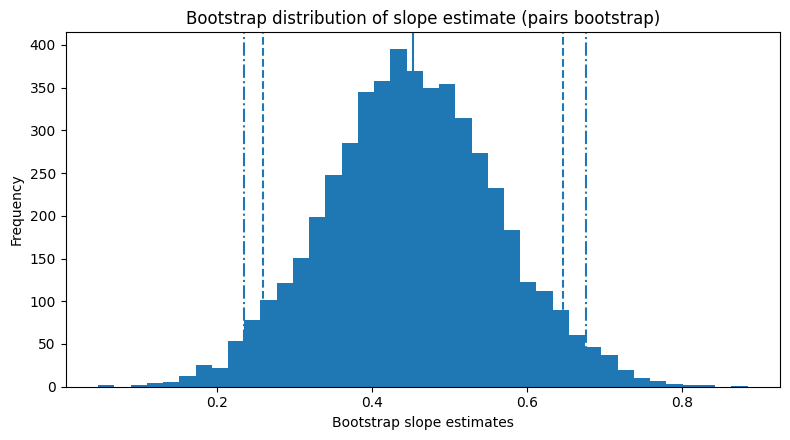

Observed slope (OLS): 0.4531383648176909
Bootstrap p-value (two-sided): 0.4888


In [3]:
# Bootstrapped vs parametric CIs for a linear regression with heteroscedastic errors
# This code will:
# 1. Generate heteroscedastic data (variance of errors increases with X)
# 2. Fit OLS and compute parametric (t-based) CI and p-value for the slope
# 3. Compute a pairs bootstrap for the slope (percentile CI)
# 4. Plot bootstrap distribution and display numeric comparisons

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# 1) Generate heteroscedastic data
n = 120
X = np.random.rand(n) * 10  # uniform 0..10
beta0 = 2.0
beta1 = 0.5
# heteroscedastic noise: sd increases with X (so variance ~ X^2)
noise_sd = 0.5 + 0.5 * X  # baseline 0.5, grows with X
eps = np.random.randn(n) * noise_sd
y = beta0 + beta1 * X + eps

# Put in DataFrame for convenience
df = pd.DataFrame({"X": X, "y": y})

# 2) Fit OLS (manual formulas) to get estimates and parametric CI for slope
X_mean = X.mean()
Sxx = ((X - X_mean)**2).sum()
# slope and intercept (OLS)
slope_hat = ((X - X_mean) * (y - y.mean())).sum() / Sxx
intercept_hat = y.mean() - slope_hat * X_mean
# residuals and sigma^2
residuals = y - (intercept_hat + slope_hat * X)
SSE = (residuals**2).sum()
df_resid = n - 2
sigma2_hat = SSE / df_resid
# standard error for slope
se_slope = sqrt(sigma2_hat / Sxx)

# t critical value (try scipy, otherwise normal approx)
try:
    from scipy import stats
    tcrit = stats.t.ppf(0.975, df_resid)
    pval_slope = 2 * (1 - stats.t.cdf(abs(slope_hat / se_slope), df_resid))
except Exception:
    # fallback to normal approximation
    from math import erf, sqrt as _sqrt
    tcrit = 1.96
    from math import erfc
    # approximate p-value using normal
    import math
    z = abs(slope_hat / se_slope)
    pval_slope = 2 * (1 - 0.5 * (1 + math.erf(z / math.sqrt(2))))

ci_param_lower = slope_hat - tcrit * se_slope
ci_param_upper = slope_hat + tcrit * se_slope

# 3) Pairs bootstrap for slope (resample rows)
n_boot = 5000
boot_slopes = np.empty(n_boot)
rng = np.random.default_rng(12345)
for i in range(n_boot):
    idx = rng.integers(0, n, n)
    Xb = X[idx]
    yb = y[idx]
    Xb_mean = Xb.mean()
    Sxx_b = ((Xb - Xb_mean)**2).sum()
    slope_b = ((Xb - Xb_mean) * (yb - yb.mean())).sum() / Sxx_b
    boot_slopes[i] = slope_b

# bootstrap percentile CI
ci_boot_lower = np.percentile(boot_slopes, 2.5)
ci_boot_upper = np.percentile(boot_slopes, 97.5)
boot_mean = boot_slopes.mean()
boot_se = boot_slopes.std(ddof=1)

# 4) Output summary and plot
summary = pd.DataFrame({
    "estimate_method": ["OLS (parametric)", "Bootstrap (pairs)"],
    "slope_estimate": [slope_hat, boot_mean],
    "se_estimate": [se_slope, boot_se],
    "ci_lower": [ci_param_lower, ci_boot_lower],
    "ci_upper": [ci_param_upper, ci_boot_upper]
})

# Print p-value and quick diagnostics
print("OLS slope estimate:         ", slope_hat)
print("Parametric SE (slope):      ", se_slope)
print(f"Parametric 95% CI (slope):  [{ci_param_lower:.4f}, {ci_param_upper:.4f}]")
print("Parametric two-sided p-val: ", f"{pval_slope:.4g}")
print()
print("Bootstrap mean slope:       ", boot_mean)
print(f"Bootstrap 95% percentile CI: [{ci_boot_lower:.4f}, {ci_boot_upper:.4f}]")
print("Bootstrap SE (sd of boots): ", boot_se)

# Plot bootstrap distribution and parametric CI
plt.figure(figsize=(8,4.5))
plt.hist(boot_slopes, bins=40, density=False)
plt.xlabel("Bootstrap slope estimates")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution of slope estimate (pairs bootstrap)")
# vertical lines: OLS estimate and both CIs
plt.axvline(slope_hat, linestyle="solid")
plt.axvline(ci_param_lower, linestyle="dashed")
plt.axvline(ci_param_upper, linestyle="dashed")
plt.axvline(ci_boot_lower, linestyle="dashdot")
plt.axvline(ci_boot_upper, linestyle="dashdot")
plt.tight_layout()
plt.show()

# Bootstrap p-value: fraction of bootstrap slopes as extreme as observed relative to null=0
obs_slope = slope_hat
extreme_count = np.sum(np.abs(boot_slopes) >= np.abs(obs_slope))
pval_boot = extreme_count / n_boot

print("Observed slope (OLS):", obs_slope)
print("Bootstrap p-value (two-sided):", pval_boot)
